In [40]:
import pandas as pd
!pip install openpyxl

# 파일 읽기
file_path = './data/한국어-영어 번역(병렬) 말뭉치/2_conversation_200226.xlsx'
df = pd.read_excel(file_path)

# 데이터 정보 확인
print(df.info())  # 데이터 구조 및 열 정보 확인
print(df.head())  # 첫 몇 행 출력

# 데이터 처리
df = df.dropna()  # 결측치 제거
df = df[['원문', '번역문']]  # 필요한 열만 선택


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   대분류      100000 non-null  object
 1   소분류      100000 non-null  object
 2   상황       100000 non-null  object
 3   Set Nr.  100000 non-null  int64 
 4   발화자      100000 non-null  object
 5   원문       100000 non-null  object
 6   번역문      100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
    대분류 소분류       상황  Set Nr.  발화자                            원문  \
0  비즈니스  회의  의견 교환하기        1  A-1   이번 신제품 출시에 대한 시장의 반응은 어떤가요?   
1  비즈니스  회의  의견 교환하기        1  B-1    판매량이 지난번 제품보다 빠르게 늘고 있습니다.   
2  비즈니스  회의  의견 교환하기        1  A-2  그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.   
3  비즈니스  회의  의견 교환하기        1  B-2   네, 제가 연락해서 주문량을 2배로 늘리겠습니다.   
4  비즈니스  회의  의견 교환하기        2  A-1   지난 회의 마지막에 논의했던 안건을 다시 볼까요?   

                                                 번역문  
0  How is the market's reactio

In [2]:
df

,원문,번역문
0,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...
...,...,...
99995,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...
99996,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?
99997,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph..."
99998,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de..."


In [3]:
kor = df['원문']
eng = df['번역문']

In [4]:
!pip install spacy
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.5 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [7]:
from tqdm import tqdm
from spacy.matcher import Matcher
matcher = Matcher(nlp.vocab)
passive_rules = [
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBN'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'RB'}, {'TAG': 'VBN'}],
]

matcher.add("Passive", passive_rules)

# 수동문 개수 계산 함수
def count_passive_sentences(text):
    doc = nlp(text)  # 텍스트 처리
    matches = matcher(doc)  # Matcher로 패턴 매칭
    return len(matches)  # 매칭된 패턴 개수 반환

eng_passive_counts = []
for text in tqdm(eng, desc="Processing Sentences"):
    count = count_passive_sentences(text)
    eng_passive_counts.append(count)


# 결과를 데이터프레임에 추가
df["eng_passive_count"] = eng_passive_counts

# passive_count가 1 이상인 행만 남기기
df = df[df["eng_passive_count"] > 0].reset_index(drop=True)


Processing Sentences: 100%|██████████| 100000/100000 [06:50<00:00, 243.50it/s]


In [ ]:
df

In [8]:
kor = df['원문']
eng = df['번역문']

In [49]:
#%pip install -U konlpy
import re
from konlpy.tag import Kkma
kkma = Kkma()

# 피동문 유형별 패턴 감지 함수
def count_korean_passive_sentences(text):
    tokens = kkma.pos(text)  # 형태소 분석
    
    # 각 피동 탐지 조건별 결과 저장
    detected_patterns = {
        "passive_suffix": [],
        "passive_auxiliary": [],
        "passive_verb": []
    }
    # 피동 접미사 "-이/히/리/기-" 패턴
    for tok in tokens:
        if tok[1] == 'VV' and tok[0].endswith(('이', '히', '리', '기')):
            detected_patterns["passive_suffix"].append(tok)

    # 보조동사 "-어지-" 패턴
    for i in range(len(tokens) - 2):
        if (tokens[i][1] == 'VV' and tokens[i+1][0] == '어' and
            tokens[i+2][0] == '지' and tokens[i+2][1] == 'VXV'):
            detected_patterns["passive_auxiliary"].append((tokens[i], tokens[i+1], tokens[i+2]))

    # "-되다", "-받다", "-당하다" 패턴
    for tok in tokens:
        if tok[1] == 'VV' and re.search(r'^\s*받|^(되|당하)', tok[0]):
            detected_patterns["passive_verb"].append(tok)
    
    # 총 탐지 개수 반환
    total_count = sum(len(matches) for matches in detected_patterns.values())
    return total_count

In [27]:
kor_passive_counts = []
for text in tqdm(kor, desc="Processing Sentences"):
    count = count_korean_passive_sentences(text)
    kor_passive_counts.append(count)


# 결과를 데이터프레임에 추가
df["kor_passive_count"] = kor_passive_counts

Processing Sentences: 100%|██████████| 6467/6467 [01:49<00:00, 58.80it/s]


In [41]:
kor = df['원문']
eng = df['번역문']
df["eng_passive_count"] = eng_passive_counts
df = df[df["eng_passive_count"] > 0].reset_index(drop=True)
df["kor_passive_count"] = kor_passive_counts
df = df[['원문', '번역문', 'kor_passive_count', 'eng_passive_count']]

In [47]:
pd.set_option('display.min_rows', 100)
df

,원문,번역문,kor_passive_count,eng_passive_count
0,우리 제품은 어떤 방식으로 도쿄에 보내지나요?,How will our products be shipped to Tokyo?,0,1
1,먼저 배로 도쿄 근처 항구까지 운반하고 그 후 차를 이용합니다.,"They'll be sent to Tokyo port by the ship, the...",0,1
2,교육 안내 메일 하단에 작은 글씨로 적혀있어요.,It was written in very small letters at the bo...,1,1
3,7월 29일부터 8월 2일까지가 공식적인 기간이에요.,It's officially scheduled from July 29 to Augu...,0,1
4,"네, 메일로 이미 공지를 했으니 다들 알고 있을 거에요.","Sure, but they'd already known since it was no...",0,1
5,인턴 5명을 포함해서 많은 직원을 뽑았다고 들었어요.,I was told that you hired many employees inclu...,0,1
6,그럼 광고 외에 출시까지 남은 과정은 무엇이 있나요?,"Then, what procedures are left before the rele...",0,1
7,"네, 저희 층의 직원들은 모두 제출했다고 들었어요.","Yes, I was told that every employee on my floo...",0,1
8,그보다 훨씬 더 많이 모여서 모두 뿌듯해했어요.,"It was raised way more than we planned, so we ...",1,1
9,좋은 아이디어네요. 먼저 전체 회의 때 통과된다면요.,That's a great idea. I hope it'll be approved ...,0,1


In [52]:
def debug_korean_passive_detection(text):
    tokens = kkma.pos(text)  # 형태소 분석
    print(f"Input Sentence: {text}")
    print(f"Tokens: {tokens}\n")
    
    # 각 피동 탐지 조건별 결과 저장
    detected_patterns = {
        "passive_suffix": [],
        "passive_auxiliary": [],
        "passive_verb": []
    }

    # 피동 접미사 "-이/히/리/기-" 패턴
    for tok in tokens:
        if tok[1] == 'VV' and tok[0].endswith(('이', '히', '리', '기')):
            detected_patterns["passive_suffix"].append(tok)

    # 보조동사 "-어지-" 패턴
    for i in range(len(tokens) - 2):
        if (tokens[i][1] == 'VV' and tokens[i+1][0] == '어' and
            tokens[i+2][0] == '지' and tokens[i+2][1] == 'VXV'):
            detected_patterns["passive_auxiliary"].append((tokens[i], tokens[i+1], tokens[i+2]))

    # "-되다", "-받다", "-당하다" 패턴
    for tok in tokens:
        if tok[1] == 'VV' and re.search(r'(?<!\s).받|^(되|당하)', tok[0]):
            detected_patterns["passive_verb"].append(tok)

    # 디버깅 정보 출력
    for pattern, matches in detected_patterns.items():
        print(f"Detected {pattern}: {matches}")
    
    # 총 탐지 개수 반환
    total_count = sum(len(matches) for matches in detected_patterns.values())
    print(f"\nTotal Passive Matches: {total_count}\n")
    return total_count


In [ ]:
print('nsubjpass:', spacy.explain("nsubjpass"))
print('aux:', spacy.explain("aux"))
print('VBN:', spacy.explain("VBN"))
print('VBZ:', spacy.explain("VBZ"))
print('RB:', spacy.explain("RB"))

/tmp/ipykernel_2985/181758785.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_summary, x="variable", y="value", palette="coolwarm")


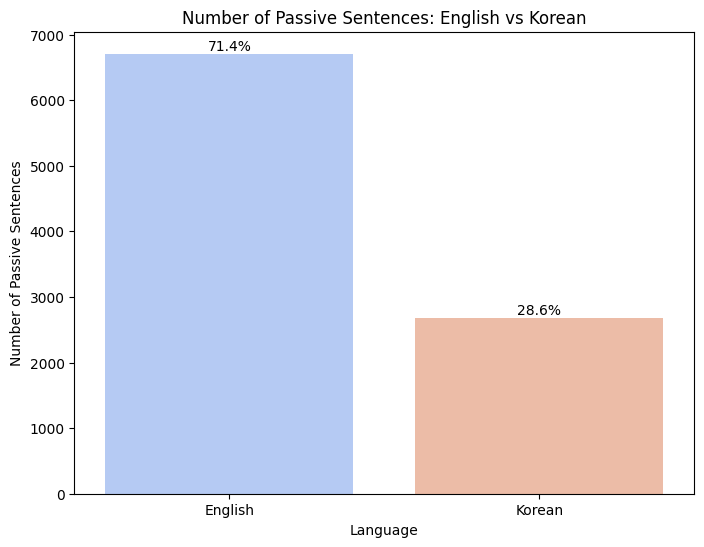

In [ ]:
# 시각화: 영어와 한국어 수동문 비교 (퍼센트 포함)
import matplotlib.pyplot as plt
import seaborn as sns

# 원문과 번역문 별 수동문 합계 계산
df_summary = df.melt(id_vars=["원문", "번역문"], 
                     value_vars=["eng_passive_count", "kor_passive_count"]) \
               .groupby("variable").sum().reset_index()

# 퍼센트 계산
df_summary["percentage"] = (df_summary["value"] / df_summary["value"].sum()) * 100

# 시각화
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_summary, x="variable", y="value", palette="coolwarm")
plt.title("Number of Passive Sentences: English vs Korean")
plt.ylabel("Number of Passive Sentences")
plt.xlabel("Language")
plt.xticks([0, 1], ["English", "Korean"])

# 바 위에 퍼센트 표시
for i, row in df_summary.iterrows():
    ax.text(i, row["value"] + 1, f'{row["percentage"]:.1f}%', ha="center", va="bottom")

plt.show()

/tmp/ipykernel_2985/1171816925.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=change_counts.index, y=change_counts.values, palette="viridis")
/tmp/ipykernel_2985/1171816925.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, count + 0.2, f'{percentages[i]:.1f}%', ha='center', va='bottom', fontsize=12)


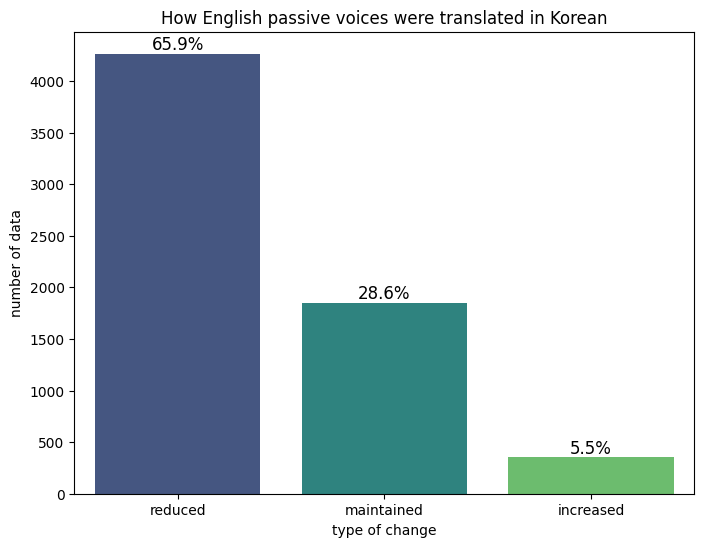

In [60]:
# 범주화: 줄어듦, 유지됨, 증가됨
def categorize_passive_difference(row):
    if row["kor_passive_count"] < row["eng_passive_count"]:
        return "reduced"
    elif row["kor_passive_count"] == row["eng_passive_count"]:
        return "maintained"
    else:
        return "increased"

df["passive_change"] = df.apply(categorize_passive_difference, axis=1)

# 각 범주의 개수 계산
change_counts = df["passive_change"].value_counts()

#퍼센트 계산
total = change_counts.sum()
percentages = (change_counts / total) * 100

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=change_counts.index, y=change_counts.values, palette="viridis")

for i, count in enumerate(change_counts.values):
    plt.text(i, count + 0.2, f'{percentages[i]:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title("How English passive voices were translated in Korean")
plt.xlabel("type of change")
plt.ylabel("number of data")
plt.show()